In [1]:
import time
import os
import shutil
import sys
import h5py
import tensorflow                             as tf
import numpy                                  as np
import seaborn                                as sns
import pandas                                 as pd
import numpy.random                           as random
from sklearn.utils                        import shuffle
from sklearn.model_selection              import train_test_split
from tqdm                                 import tqdm
from os                                   import path
import pysftp                                 as sftp
import random                                 as rnd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes


LocalFlg         = 'False'
if (not LocalFlg):
    WORKSPACE_PATH = "/home/venturi/WORKSPACE/"
    IP             = '128.174.245.172'
    User           = "venturi"
else:
    WORKSPACE_PATH = os.getenv('WORKSPACE_PATH')  
    
import matplotlib as mpl
import matplotlib.pyplot                      as plt

print("="*50)
print(" TensorFlow version: {}".format(tf.__version__))
print(" Eager execution: {}".format(tf.executing_eagerly()))

 TensorFlow version: 2.4.1
 Eager execution: True


In [2]:
pd.set_option('display.max_columns', None)  
sns.set_style('ticks')
plt.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']
# plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{tikz} \usepackage[utf8]{inputenc}')
plt.rc('font', family='Times')
sns.set_context("paper")

# Tick parameters
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 2

plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 30

<ipython-input-2-c08182972d77>:4: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']


In [3]:
Dimension   = 'nondim'
InelRunNb   = 9
ExchRunNb   = 6
DissRunNb   = 55
ReactionFlgQCT    = '2_1_1_0'
ReactionFlgSurQCT = '2_1_1_0'
TTranVec = [5000, 8000, 10000, 12000, 20000]
PopPlotTime = [1e-6]

import Initialize_System
import Initialize_Paths as Paths

SystName    = 'O3_UMN'
Initialize = getattr(Initialize_System,'Initialize_'+SystName)
System = Initialize()

QCT_ME_path    = Paths.Workspace_path + 'Air_Database/' + System.QCTMEPath
SurQCT_ME_path = Paths.Workspace_path + 'Air_Database/Run_0D_surQCT/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

Data_ME_path   = Paths.Surqct_path + '0D/Data/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'
Figure_ME_path = Paths.Surqct_path + '0D/Figures/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

print('QCT Master Equation Path    :', QCT_ME_path)
print('SurQCT Master Equation Path :', SurQCT_ME_path)
print('Data Master Equation Path   :', Data_ME_path)
print('Figures Master Equation Path:', Figure_ME_path)

QCT Master Equation Path    : /home/venturi/WORKSPACE/Air_Database/Run_0D/
SurQCT Master Equation Path : /home/venturi/WORKSPACE/Air_Database/Run_0D_surQCT/nondim_RunI9_E6_D55/
Data Master Equation Path   : /home/venturi/WORKSPACE/SurQCT/0D/Data/O3_UMN/nondim_RunI9_E6_D55/
Figures Master Equation Path: /home/venturi/WORKSPACE/SurQCT/0D/Figures/O3_UMN/nondim_RunI9_E6_D55/


In [4]:
SurQCTFldr          = Paths.Workspace_path + '/SurQCT/surqct/'

RatesType           = 'KExcit'
ExcitType           = 'KInel'
NNRunIdx            = 9

PathToRunFld        = SurQCTFldr + '/../' + RatesType + '/all_temperatures_nondim/' + ExcitType + '/' 

MinRate             = 1.e-15

iIdxVec             = np.array([110,3500], dtype=int)


# Reading Files
print("\n[SurQCT]: Loading Modules and Functions ...")

sys.path.insert(0, SurQCTFldr  + '/src/Reading/')
from Reading  import read_levelsdata, read_diatdata

InputFld = PathToRunFld + '/Run_' + str(NNRunIdx) + '/'
print(InputFld)
sys.path.insert(0, InputFld)

# Initialize Input Data
print("\n[SurQCT]: Keep Loading Modules and Functions...")
from SurQCT_Input import inputdata

print("\n[SurQCT]: Initializing Input ...")
InputData    = inputdata(WORKSPACE_PATH, SurQCTFldr)

Prefix                    = 'Run_'
InputData.NNRunIdx        = NNRunIdx
InputData.PathToRunFld    = InputData.PathToRunFld+'/'+Prefix+str(InputData.NNRunIdx)
InputData.PathToFigFld    = InputData.PathToRunFld+'/'+InputData.PathToFigFld
InputData.PathToParamsFld = InputData.PathToRunFld+'/'+InputData.PathToParamsFld
InputData.PathToDataFld   = InputData.PathToRunFld+'/Data/'                                                               
InputData.PathToParamsFld = InputData.PathToRunFld+'/Params/'

# Read NN Model
print("\n[SurQCT]: Loading Final Modules ... ")

sys.path.insert(0, SurQCTFldr  + '/src/Model/' + InputData.ApproxModel + '/')
from Model import model


InputData.DefineModelIntFlg  = 0
InputData.TrainIntFlg        = 0
InputData.TransferFlg        = False
NN_KExcit                    = model(InputData, InputData.PathToRunFld, None, None)
NN_KExcit.load_params(InputData.PathToParamsFld)

OtherVar           = InputData.OtherVar
xVarsVec_i         = InputData.xVarsVec_i + ['vqn','jqn']
xVarsVec_Delta     = InputData.xVarsVec_Delta
xVarsVec           = list(set(xVarsVec_i) | set(xVarsVec_Delta))
print('[SurQCT]:   Reading Variables: ', xVarsVec)

InputData.MultFact = 1.e+9
MinValueTrain      = 1.e-16 * InputData.MultFact
MinValueTest       = 1.e-16 * InputData.MultFact
NoiseSD            = 1.e-13 * InputData.MultFact

NMolecules         = len(InputData.PathToLevelsFile)

InputData.iLevelsVecTest = list(np.array(InputData.iLevelsVecTest) - 1)

# Reading Levels Data
LevelsData = []
DiatData   = []
DiatData2  = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(InputData.PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(InputData.PathToDiatFile[iMol], InputData.Molecules[iMol], TTranVec, TTranVec)
    DiatData.append(DiatDataTemp)
    
    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)


[SurQCT]: Loading Modules and Functions ...
/home/venturi/WORKSPACE//SurQCT/surqct//../KExcit/all_temperatures_nondim/KInel//Run_9/

[SurQCT]: Keep Loading Modules and Functions...

[SurQCT]: Initializing Input ...

[SurQCT]: Loading Final Modules ... 
[SurQCT]:   Variables Selected for Training:
[SurQCT]:     x =  ['log_EVib_i', 'log_ERot_i', 'ri_i', 'log_rorMin_i', 'TTran_i', 'log_EVib_Delta', 'log_ERot_Delta', 'ri_Delta', 'log_rorMin_Delta', 'TTran_Delta']
[SurQCT]:     y =  KExcit
[SurQCT]:   Loading ML Model from Folder: /home/venturi/WORKSPACE//SurQCT/surqct//../KExcit/all_temperatures_nondim/KInel//Run_9/MyModel
[SurQCT]:   Restoring ML Model Weigths to File: /home/venturi/WORKSPACE//SurQCT/surqct//../KExcit/all_temperatures_nondim/KInel//Run_9/MyModel/MyWeights.h5
[SurQCT]:   Loading ML Model Parameters from File:  /home/venturi/WORKSPACE//SurQCT/surqct//../KExcit/all_temperatures_nondim/KInel//Run_9/Params//ModelCheckpoint/cp-1963.ckpt
[SurQCT]:   Reading Variables:  ['jqn', 

In [5]:
def read_HDF5(System, PathToHDF5File, TTra, TInt):                                                                                           
    print('[HCN]:   Reading Rates Data from: ' + PathToHDF5File)                                                                             
    HDF5Exist_Flg = path.exists(PathToHDF5File)                                                                                              
    if (HDF5Exist_Flg):                                                                                                                      
        f = h5py.File(PathToHDF5File, 'a')                                                                                                   
    else:                                                                                                                                    
        f = {'key': 'value'}                                                                                                                 
                                                                                                                                             
    try:                                                                                                                                     
        TStr  = 'T_' + str(int(TTra)) + '_' + str(int(TInt)) + '/Rates/'                                                                     
        grp   = f[TStr]                                                                                                                      
        Data  = grp["Diss"]                                                                                                                  
        System.Rates.KDiss = Data[...]                                                                                                       
        Data  = grp["Inel"]                                                                                                                  
        System.Rates.KInel = Data[...]                                                                                                       
                                                                                                                                             
        KExch = []                                                                                                                           
        for iProc in range(2, System.NbProcesses):                                                                                           
            ExchStr    = "Exch_" + str(iProc-1)                                                                                              
            Data       = grp[ExchStr]                                                                                                        
            System.Rates.KExch[iProc] = Data[...]                                                                                            
        f.close()                                                                                                                            
                                                                                                                                             
    except:                                                                                                                                  
        KDiss = None                                                                                                                         
                                                                                                                                             
    return System

[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database/O3_UMN.hdf5


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes:   0%|          | 0/2 [00:00<?, ?it/s]

Level: 109; vqn: 1; jqn:38


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s]

Level: 3499; vqn: 28; jqn:48


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database/O3_UMN.hdf5


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes:   0%|          | 0/2 [00:00<?, ?it/s]

Level: 109; vqn: 1; jqn:38


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s]

Level: 3499; vqn: 28; jqn:48


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]


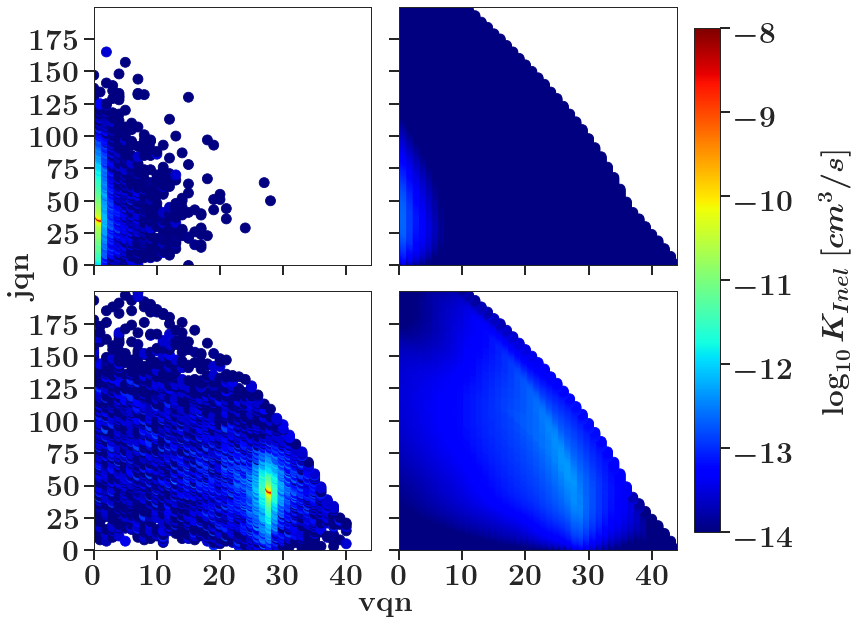

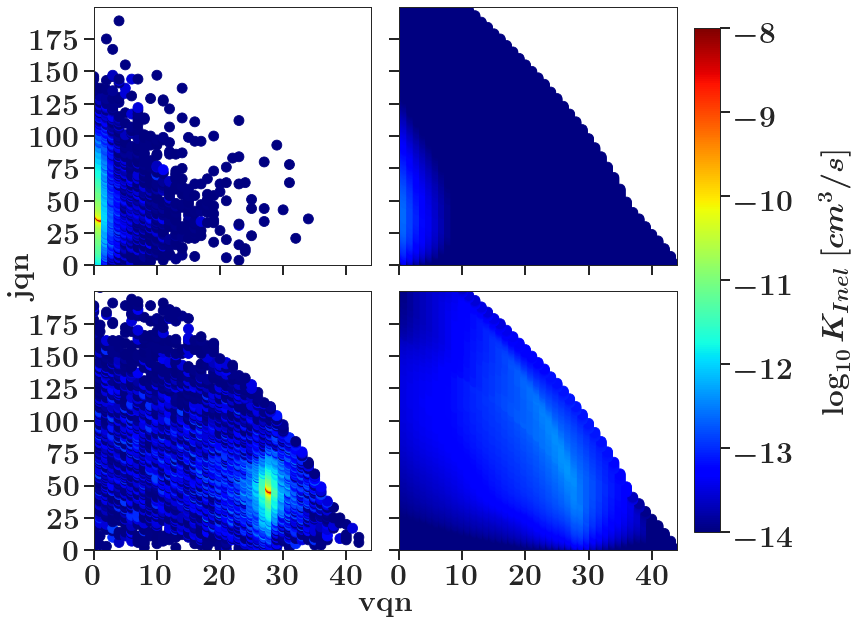

In [6]:
for TTran in TTranVec:
    Str = 'q_'+str(int(TTran))

    # Read Rates
    PathToHDF5File = System.PathToHDF5Fld+System.Name+'.hdf5'
    System = read_HDF5(System, PathToHDF5File, TTran, TTran)

    fig, axs = plt.subplots(2,2,sharey=True,sharex=True,figsize=(12,10))
    iplot = 0
    iplotc = 0
    for iIdx in tqdm(iIdxVec, desc='[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes'):
        iIdx -= 1
        print('Level: '+str(iIdx)+'; vqn: '+str(DiatData[0]['vqn'].to_numpy()[iIdx])+'; jqn:'+str(DiatData[0]['jqn'].to_numpy()[iIdx]))
        time.sleep(0.02)

        if (InputData.ExoEndoFlg):
            jIdxVec           = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] <= DiatData[0]['EInt'].to_numpy()[iIdx])]
            jIdxVecNo         = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] > DiatData[0]['EInt'].to_numpy()[iIdx])]
            RatioNo           = [DiatData[0][Str].to_numpy()[iIdx]/DiatData[1][Str].to_numpy()[jIdx] for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] > DiatData[0]['EInt'].to_numpy()[iIdx])]
        else:
            jIdxVec           = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    >= DiatData[0][Str].to_numpy()[iIdx])]
            jIdxVecNo         = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    < DiatData[0][Str].to_numpy()[iIdx])]
            RatioNo           = [DiatData[0][Str].to_numpy()[iIdx]/DiatData[1][Str].to_numpy()[jIdx] for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    < DiatData[0][Str].to_numpy()[iIdx])]
        jNLevels              = len(jIdxVec)
        jNLevelsNo            = len(jIdxVecNo)  

        ### FWD Rates
        iiIdxVec              = [iIdx]*jNLevels

        iTTranVec              = np.ones((jNLevels))*TTran
        TTranDataTemp         = pd.DataFrame({'TTran': iTTranVec})
        TTranDataTemp.index   = jIdxVec


        iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
        iLevelsDataTemp.index = jIdxVec

        jLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
        if (OtherVar == '_Delta'):
            jLevelsDataTemp   = iLevelsDataTemp.subtract(jLevelsDataTemp) 
        else:
            jLevelsDataTemp   = jLevelsDataTemp
        jLevelsDataTemp.index = jIdxVec

        kLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
        kLevelsDataTemp.index = jIdxVec


        iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

        jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
        jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

        kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        kLevelsData.columns   = [(VarName + '_j') for VarName in kLevelsData.columns]

        xTemp_FWD             = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)

        if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
            KExcit_NN_FWD          = np.exp( NN_KExcit.Model.predict(xTemp_FWD[NN_KExcit.xTrainingVar]) ) / InputData.MultFact 

        ## BWD Rates
        iiIdxVec              = jIdxVecNo
        jIdxVec               = [iIdx]*jNLevelsNo

        iTTranVec              = np.ones((jNLevelsNo))*TTran
        TTranDataTemp         = pd.DataFrame({'TTran': iTTranVec})
        TTranDataTemp.index   = iiIdxVec


        iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
        iLevelsDataTemp.index = iiIdxVec

        jLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy() 
        jLevelsDataTemp.index = iiIdxVec
        if (OtherVar == '_Delta'):
            jLevelsDataTemp   = iLevelsDataTemp.subtract(jLevelsDataTemp) 
        else:
            jLevelsDataTemp   = jLevelsDataTemp

        kLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
        kLevelsDataTemp.index = iiIdxVec


        iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

        jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
        jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

        kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        kLevelsData.columns   = [(VarName + '_j') for VarName in kLevelsData.columns]

        xTempp_BWD            = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)

        if (len(xTempp_BWD[NN_KExcit.xTrainingVar]) > 0):
            KExcit_NN_BWD          = np.exp( NN_KExcit.Model.predict(xTempp_BWD[NN_KExcit.xTrainingVar]) ) / InputData.MultFact 
            KExcit_NN_BWD[:,0]     = KExcit_NN_BWD[:,0] / RatioNo

            iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
            iLevelsData.columns   = [(VarName + '_j') for VarName in iLevelsData.columns]

            jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
            jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

            kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
            kLevelsData.columns   = [(VarName + '_i') for VarName in kLevelsData.columns]

            xTemp_BWD             = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)

        ### Concatenating
            if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
                xTemp     = pd.concat([xTemp_FWD, xTemp_BWD], axis=0)
                KExcit_NN = np.concatenate((KExcit_NN_FWD, KExcit_NN_BWD), axis=0)
            else:
                xTemp     = xTemp_BWD
                KExcit_NN = KExcit_NN_BWD
        else:
            if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
                xTemp     = xTemp_FWD
                KExcit_NN = KExcit_NN_FWD

        ### Plotting
        Mask     = System.Rates.KInel[iIdx,:] > MinRate

        vmax     = -8
        vmin     = -14

        cdict = {
          'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
          'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
          'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
        }
        
        axs[iplotc][iplot].scatter(DiatData[1]['vqn'][Mask], DiatData[1]['jqn'][Mask],s=100, c=np.log10(System.Rates.KInel[iIdx,Mask]), vmin=vmin, vmax=vmax,cmap='jet')
        axs[iplotc][iplot].set_xlim([DiatData[1]['vqn'].min(), DiatData[1]['vqn'].max()])
        axs[iplotc][iplot].set_ylim([DiatData[1]['jqn'].min(), 200])

        sc = axs[iplotc][iplot+1].scatter(xTemp['vqn_j'], xTemp['jqn_j'], c=np.log10(KExcit_NN[:,0]),s=100, vmin=vmin, vmax=vmax,cmap='jet')
        axs[iplotc][iplot+1].set_xlim([DiatData[1]['vqn'].min(), DiatData[1]['vqn'].max()])
        axs[iplotc][iplot+1].set_ylim([DiatData[1]['jqn'].min(), 200])
        axs[iplotc][iplot+1].set_xticks([0,10,20,30,40])
        axs[iplotc][iplot+1].set_yticks([0,25,50,75,100,125,150,175])

        iplotc = iplotc + 1
    
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel('\\textbf{vqn}',labelpad=40)
    plt.ylabel('\\textbf{jqn}',labelpad=60)
    
#     fig.subplots_adjust(right=0.8)
    fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label('$\log_{10}{K_{Inel}}$ \\textbf{[}$cm^3/s$\\textbf{]}', rotation=90,labelpad=25,size=30)

#     fig.tight_layout(pad=2.0) 
#     plt.savefig((Figure_ME_path+System.Name+'_T'+str(TTran)+'K_KInel.pdf'), format='pdf',dpi=600)


# Plot on Diatomic Potential

[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database/O3_UMN.hdf5


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes: 100%|██████████| 6/6 [00:00<00:00, 44.82it/s]
<ipython-input-7-dd6129bb2f8e>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


Level: 109; vqn: 1; jqn:38
Level: 3499; vqn: 28; jqn:48
Level: 4999; vqn: 20; jqn:127
Level: 1199; vqn: 14; jqn:12
Level: 5999; vqn: 0; jqn:222
Level: 2391; vqn: 7; jqn:125
[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database/O3_UMN.hdf5


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes: 100%|██████████| 6/6 [00:00<00:00, 44.54it/s]


Level: 109; vqn: 1; jqn:38
Level: 3499; vqn: 28; jqn:48
Level: 4999; vqn: 20; jqn:127
Level: 1199; vqn: 14; jqn:12
Level: 5999; vqn: 0; jqn:222
Level: 2391; vqn: 7; jqn:125


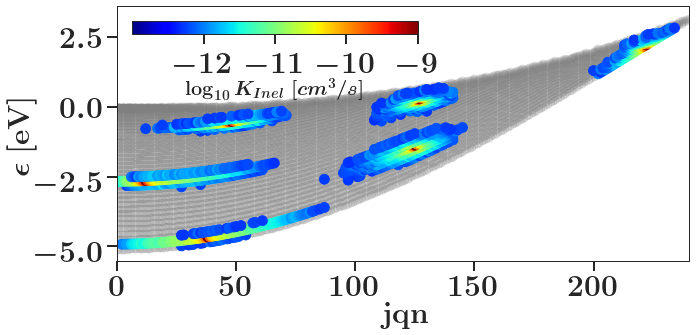

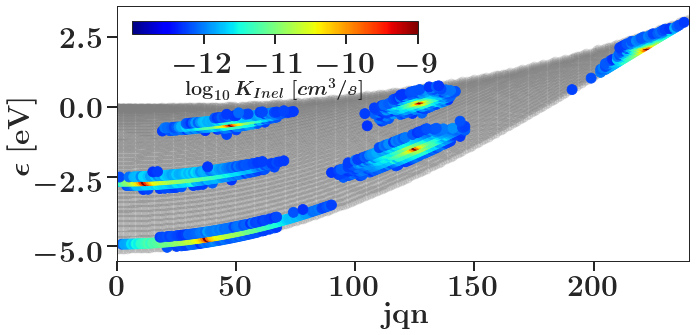

In [7]:
iIdxVec             = np.array([110,3500, 5000, 1200, 6000, 2392], dtype=int)

for TTran in TTranVec:
    Str = 'q_'+str(int(TTran))

    # Read Rates
    PathToHDF5File = System.PathToHDF5Fld+System.Name+'.hdf5'
    System = read_HDF5(System, PathToHDF5File, TTran, TTran)

    fig, axs = plt.subplots(1,1,figsize=(10,5))
    sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=50, c='grey',alpha=0.2)
    
    for iIdx in tqdm(iIdxVec, desc='[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes'):
        iIdx -= 1
        print('Level: '+str(iIdx)+'; vqn: '+str(DiatData[0]['vqn'].to_numpy()[iIdx])+'; jqn:'+str(DiatData[0]['jqn'].to_numpy()[iIdx]))
        time.sleep(0.02)

 
        ### Plotting
        Mask     = System.Rates.KInel[iIdx,:] > 5e-13

        vmax     = -9
        vmin     = -13
        
        sc = axs.scatter(DiatData[1]['jqn'][Mask], DiatData[1]['EInt'][Mask],s=100, c=np.log10(System.Rates.KInel[iIdx,Mask]), vmin=vmin, vmax=vmax,cmap='jet')
    
    axs.set_xlim([DiatData[1]['jqn'].min(), DiatData[1]['jqn'].max()])
#     axs.set_ylim([DiatData[1]['jqn'].min(), 200])
#     axs.set_xticks([0,10,20,30,40])
#     axs.set_yticks([0,25,50,75,100,125,150,175])

    axins1 = inset_axes(axs,
                        width="50%",  # width = 50% of parent_bbox width
                        height="5%",  # height : 5%
                        loc='upper left')
    
    cbar = fig.colorbar(sc, cax=axins1, orientation="horizontal", ticks=[-12,-11,-10,-9])
    axins1.xaxis.set_ticks_position("bottom")    
    cbar.set_label('$\log_{10}{K_{Inel}}$ \\textbf{[}$cm^3/s$\\textbf{]}',fontsize=20)

    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel('\\textbf{jqn}',labelpad=40)
    plt.ylabel('$\epsilon$ \\textbf{[eV]}',labelpad=80)
    
    
    fig.tight_layout(pad=2.0) 
    plt.savefig(('/home/venturi/WORKSPACE/SurQCT/0D/Figures/OUSD_poster/T'+str(TTran)+'K_KInel.pdf'), format='pdf',dpi=600)


## Correlation plot 

In [11]:
SaveFigures = False

In [50]:
NIdx = 100
KExcit_Scatter = []
sampled_levels = []
KExcitNN_Scatter = []

for TTran in TTranVec:
    Str = 'q_'+str(int(TTran))

    print('[SurQCT]:    TTran = ', TTran)
    iIdxVec = np.arange(NLevels[0])
    sampled_levels_temp = rnd.choices(list(iIdxVec), k=NIdx)
    
    # Read Rates
    PathToHDF5File = System.PathToHDF5Fld+System.Name+'.hdf5'
    PathToHDF5File = '/home/venturi/WORKSPACE/Air_Database/HDF5_Database_AmalInel/'+System.Name+'.hdf5'
    System = read_HDF5(System, PathToHDF5File, TTran, TTran)
    
    for iIdx in sampled_levels_temp:
        iIdx -= 1
#         print('Level: '+str(iIdx)+'; vqn: '+str(DiatData[0]['vqn'].to_numpy()[iIdx])+'; jqn:'+str(DiatData[0]['jqn'].to_numpy()[iIdx]))
        time.sleep(0.02)

        if (InputData.ExoEndoFlg):
            jIdxVec           = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] <= DiatData[0]['EInt'].to_numpy()[iIdx])]
            jIdxVecNo         = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] > DiatData[0]['EInt'].to_numpy()[iIdx])]
            RatioNo           = [DiatData[0][Str].to_numpy()[iIdx]/DiatData[1][Str].to_numpy()[jIdx] for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] > DiatData[0]['EInt'].to_numpy()[iIdx])]
        else:
            jIdxVec           = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    >= DiatData[0][Str].to_numpy()[iIdx])]
            jIdxVecNo         = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    < DiatData[0][Str].to_numpy()[iIdx])]
            RatioNo           = [DiatData[0][Str].to_numpy()[iIdx]/DiatData[1][Str].to_numpy()[jIdx] for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    < DiatData[0][Str].to_numpy()[iIdx])]
        jNLevels              = len(jIdxVec)
        jNLevelsNo            = len(jIdxVecNo)  

        ### FWD Rates
        iiIdxVec              = [iIdx]*jNLevels

        iTTranVec              = np.ones((jNLevels))*TTran
        TTranDataTemp         = pd.DataFrame({'TTran': iTTranVec})
        TTranDataTemp.index   = jIdxVec


        iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
        iLevelsDataTemp.index = jIdxVec

        jLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
        if (OtherVar == '_Delta'):
            jLevelsDataTemp   = iLevelsDataTemp.subtract(jLevelsDataTemp) 
        else:
            jLevelsDataTemp   = jLevelsDataTemp
        jLevelsDataTemp.index = jIdxVec

        kLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
        kLevelsDataTemp.index = jIdxVec


        iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

        jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
        jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

        kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        kLevelsData.columns   = [(VarName + '_j') for VarName in kLevelsData.columns]

        xTemp_FWD             = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)

        if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
            KExcit_NN_FWD          = np.exp( NN_KExcit.Model.predict(xTemp_FWD[NN_KExcit.xTrainingVar]) ) / InputData.MultFact
       
        ## BWD Rates
        iiIdxVec              = jIdxVecNo
        jIdxVec               = [iIdx]*jNLevelsNo

        iTTranVec              = np.ones((jNLevelsNo))*TTran
        TTranDataTemp         = pd.DataFrame({'TTran': iTTranVec})
        TTranDataTemp.index   = iiIdxVec


        iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
        iLevelsDataTemp.index = iiIdxVec

        jLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy() 
        jLevelsDataTemp.index = iiIdxVec
        if (OtherVar == '_Delta'):
            jLevelsDataTemp   = iLevelsDataTemp.subtract(jLevelsDataTemp) 
        else:
            jLevelsDataTemp   = jLevelsDataTemp

        kLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
        kLevelsDataTemp.index = iiIdxVec


        iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

        jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
        jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

        kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        kLevelsData.columns   = [(VarName + '_j') for VarName in kLevelsData.columns]

        xTempp_BWD            = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)

        if (len(xTempp_BWD[NN_KExcit.xTrainingVar]) > 0):
            KExcit_NN_BWD          = np.exp( NN_KExcit.Model.predict(xTempp_BWD[NN_KExcit.xTrainingVar]) ) / InputData.MultFact 
            KExcit_NN_BWD[:,0]     = KExcit_NN_BWD[:,0] / RatioNo

            iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
            iLevelsData.columns   = [(VarName + '_j') for VarName in iLevelsData.columns]

            jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
            jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

            kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
            kLevelsData.columns   = [(VarName + '_i') for VarName in kLevelsData.columns]

            xTemp_BWD             = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)

        ### Concatenating
            if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
                xTemp     = pd.concat([xTemp_FWD, xTemp_BWD], axis=0)
                KExcit_NN = np.concatenate((KExcit_NN_FWD, KExcit_NN_BWD), axis=0)
            else:
                xTemp     = xTemp_BWD
                KExcit_NN = KExcit_NN_BWD
        else:
            if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
                xTemp     = xTemp_FWD
                KExcit_NN = KExcit_NN_FWD

        sampled_levels_temp1 = rnd.choices(list(iIdxVec), k=100)
    
        KExcit_Scatter.append(System.Rates.KInel[iIdx,sampled_levels_temp1])
        KExcitNN_Scatter.append(KExcit_NN[sampled_levels_temp1,0])

#         System.Rates.KInel[iIdx,iIdx] = 0.0
#         KExcit_NN[iIdx,0] = 0.0
#         KExcit_Scatter.append(np.sum(System.Rates.KInel[iIdx,:]))
#         KExcitNN_Scatter.append(np.sum(KExcit_NN[sampled_levels_temp1,0]))
    
#     ax.plot([1e-13,1e-8],[1e-13,1e-8],'r',linewidth=3.0)
#     # axis properties
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlim([1.e-13, 5.e-9]) 
#     plt.ylim([1.e-13, 5.e-9])  
#     plt.xticks([1e-13,1e-11,1e-9])
#     plt.yticks([1e-13,1e-11,1e-9])

#     plt.xlabel('$k^D_{i,true}$ \\textbf{[}$cm^3/s$\\textbf{]}')
#     plt.ylabel('$k^D_{i,pred}$ \\textbf{[}$cm^3/s$\\textbf{]}')
#     plt.minorticks_off()
    
#     aspectratio=1.0
#     ax.set_aspect(1.0/1.0, adjustable='box')
#     fig.tight_layout(pad=0.5) 
#     if(SaveFigures):
#         plt.savefig((Figure_ME_path+System.Name+'_T'+str(TTran)+'K_KDissScatter.pdf'), format='pdf',dpi=300)
        


[SurQCT]:    TTran =  5000
[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database_AmalInel/O3_UMN.hdf5
[SurQCT]:    TTran =  8000
[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database_AmalInel/O3_UMN.hdf5
[SurQCT]:    TTran =  10000
[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database_AmalInel/O3_UMN.hdf5
[SurQCT]:    TTran =  12000
[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database_AmalInel/O3_UMN.hdf5
[SurQCT]:    TTran =  20000
[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database_AmalInel/O3_UMN.hdf5


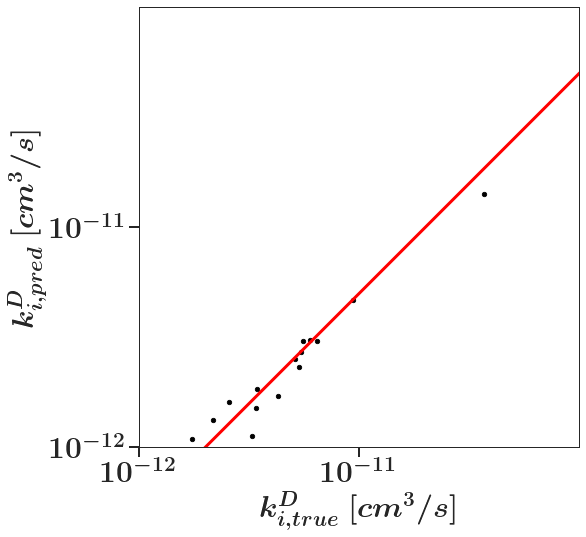

In [51]:
SaveFigures = False
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator,LogLocator)

fig,ax = plt.subplots(1,1,figsize=(8,8),sharey=True)
ax.scatter(KExcit_Scatter, KExcitNN_Scatter, s=20, c='k',label='\\textbf{QCT}')

ax.plot([2e-15,2e-8],[1e-15,1e-8],'r',linewidth=3.0)
# axis properties
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.e-12, 1.e-10]) 
plt.ylim([1.e-12, 1.e-10])  
plt.xticks([1e-12,1e-11])
plt.yticks([1e-12,1e-11])

plt.xlabel('$k^D_{i,true}$ \\textbf{[}$cm^3/s$\\textbf{]}')
plt.ylabel('$k^D_{i,pred}$ \\textbf{[}$cm^3/s$\\textbf{]}')
plt.minorticks_off()

aspectratio=1.0
ax.set_aspect(1.0/1.0, adjustable='box')
fig.tight_layout(pad=0.5) 
if(SaveFigures):
    plt.savefig((Figure_ME_path+System.Name+'_T'+str(TTran)+'K_KDissScatter.pdf'), format='pdf',dpi=300)

# N3 Plots

In [34]:
SystName    = 'N3_NASA'
Initialize = getattr(Initialize_System,'Initialize_'+SystName)
System = Initialize()

QCT_ME_path    = Paths.Workspace_path + 'Air_Database/' + System.QCTMEPath
SurQCT_ME_path = Paths.Workspace_path + 'Air_Database/Run_0D_surQCT/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

Data_ME_path   = Paths.Surqct_path + '0D/Data/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'
Figure_ME_path = Paths.Surqct_path + '0D/Figures/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

print('QCT Master Equation Path    :', QCT_ME_path)
print('SurQCT Master Equation Path :', SurQCT_ME_path)
print('Data Master Equation Path   :', Data_ME_path)
print('Figures Master Equation Path:', Figure_ME_path)

QCT Master Equation Path    : /home/venturi/WORKSPACE/Air_Database/Run_0D_semi/
SurQCT Master Equation Path : /home/venturi/WORKSPACE/Air_Database/Run_0D_surQCT/nondim_RunI9_E6_D55/
Data Master Equation Path   : /home/venturi/WORKSPACE/SurQCT/0D/Data/N3_NASA/nondim_RunI9_E6_D55/
Figures Master Equation Path: /home/venturi/WORKSPACE/SurQCT/0D/Figures/N3_NASA/nondim_RunI9_E6_D55/


In [35]:
WORKSPACE_PATH      = os.environ['WORKSPACE_PATH']
SurQCTFldr          = WORKSPACE_PATH + '/SurQCT/surqct/'

RatesType           = 'KExcit'
ExcitType           = 'KInel'
NNRunIdx            = 9

PathToRunFld        = SurQCTFldr + '/../' + RatesType + '/all_temperatures_nondim/' + ExcitType + '/' 

TTranVec            = [10000,20000]
MinRate             = 1.e-15

# iIdxVec             = np.array([1, 10, 34, 35, 81, 82, 98, 1000, 2000, 3000, 4581], dtype=int)
iIdxVec             = np.array([110,3500], dtype=int)


# Reading Files
print("\n[SurQCT]: Loading Modules and Functions ...")

sys.path.insert(0, SurQCTFldr  + '/src/Reading/')
from Reading  import read_levelsdata, read_diatdata

InputFld = PathToRunFld + '/Run_' + str(NNRunIdx) + '/'
print(InputFld)
sys.path.insert(0, InputFld)

# Initialize Input Data
print("\n[SurQCT]: Keep Loading Modules and Functions...")
from SurQCT_Input import inputdata

print("\n[SurQCT]: Initializing Input ...")
InputData    = inputdata(WORKSPACE_PATH, SurQCTFldr)

Prefix                    = 'Run_'
InputData.NNRunIdx        = NNRunIdx
InputData.PathToRunFld    = InputData.PathToRunFld+'/'+Prefix+str(InputData.NNRunIdx)
InputData.PathToFigFld    = InputData.PathToRunFld+'/'+InputData.PathToFigFld
InputData.PathToParamsFld = InputData.PathToRunFld+'/'+InputData.PathToParamsFld
InputData.PathToDataFld   = InputData.PathToRunFld+'/Data/'                                                               
InputData.PathToParamsFld = InputData.PathToRunFld+'/Params/'

InputData.PathToHDF5File  = InputData.WORKSPACE_PATH  + '/Air_Database/HDF5_Database_semiClassicalApprox/N3_NASA.hdf5'
InputData.Molecules       = ['N2','N2'] 
InputData.PathToLevelsFile= [InputData.WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/N2_LeRoy_log_nd.csv',
                             InputData.WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/N2_LeRoy_log_nd.csv']
InputData.PathToDiatFile  = [InputData.WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp',
                            InputData.WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp']   

# Read NN Model
print("\n[SurQCT]: Loading Final Modules ... ")

sys.path.insert(0, SurQCTFldr  + '/src/Model/' + InputData.ApproxModel + '/')
from Model import model


InputData.DefineModelIntFlg  = 0
InputData.TrainIntFlg        = 0
InputData.TransferFlg        = False
NN_KExcit                    = model(InputData, InputData.PathToRunFld, None, None)
NN_KExcit.load_params(InputData.PathToParamsFld)

OtherVar           = InputData.OtherVar
xVarsVec_i         = InputData.xVarsVec_i + ['vqn','jqn']
xVarsVec_Delta     = InputData.xVarsVec_Delta
xVarsVec           = list(set(xVarsVec_i) | set(xVarsVec_Delta))
print('[SurQCT]:   Reading Variables: ', xVarsVec)

InputData.MultFact = 1.e+9
MinValueTrain      = 1.e-16 * InputData.MultFact
MinValueTest       = 1.e-16 * InputData.MultFact
NoiseSD            = 1.e-13 * InputData.MultFact

NMolecules         = len(InputData.PathToLevelsFile)

InputData.iLevelsVecTest = list(np.array(InputData.iLevelsVecTest) - 1)

# Reading Levels Data
LevelsData = []
DiatData   = []
DiatData2  = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(InputData.PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(InputData.PathToDiatFile[iMol], InputData.Molecules[iMol], TTranVec, TTranVec)
    DiatData.append(DiatDataTemp)
    
    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)
    



[SurQCT]: Loading Modules and Functions ...
/home/venturi/WORKSPACE//SurQCT/surqct//../KExcit/all_temperatures_nondim/KInel//Run_9/

[SurQCT]: Keep Loading Modules and Functions...

[SurQCT]: Initializing Input ...

[SurQCT]: Loading Final Modules ... 
[SurQCT]:   Variables Selected for Training:
[SurQCT]:     x =  ['log_EVib_i', 'log_ERot_i', 'ri_i', 'log_rorMin_i', 'TTran_i', 'log_EVib_Delta', 'log_ERot_Delta', 'ri_Delta', 'log_rorMin_Delta', 'TTran_Delta']
[SurQCT]:     y =  KExcit
[SurQCT]:   Loading ML Model from Folder: /home/venturi/WORKSPACE//SurQCT/surqct//../KExcit/all_temperatures_nondim/KInel//Run_9/MyModel
[SurQCT]:   Restoring ML Model Weigths to File: /home/venturi/WORKSPACE//SurQCT/surqct//../KExcit/all_temperatures_nondim/KInel//Run_9/MyModel/MyWeights.h5
[SurQCT]:   Loading ML Model Parameters from File:  /home/venturi/WORKSPACE//SurQCT/surqct//../KExcit/all_temperatures_nondim/KInel//Run_9/Params//ModelCheckpoint/cp-1963.ckpt
[SurQCT]:   Reading Variables:  ['log_ro

In [36]:
# Read Rates
PathToHDF5File = System.PathToHDF5Fld+System.Name+'.hdf5'
System = read_HDF5(System, PathToHDF5File, TTran, TTran)

[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database_semiClassicalApprox/N3_NASA.hdf5


[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database_semiClassicalApprox/N3_NASA.hdf5


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes:   0%|          | 0/2 [00:00<?, ?it/s]

Level: 109; vqn: 2; jqn:18


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it]

Level: 3499; vqn: 22; jqn:86


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database_semiClassicalApprox/N3_NASA.hdf5


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes:   0%|          | 0/2 [00:00<?, ?it/s]

Level: 109; vqn: 2; jqn:18


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes:  50%|█████     | 1/2 [00:00<00:00,  1.14it/s]

Level: 3499; vqn: 22; jqn:86


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


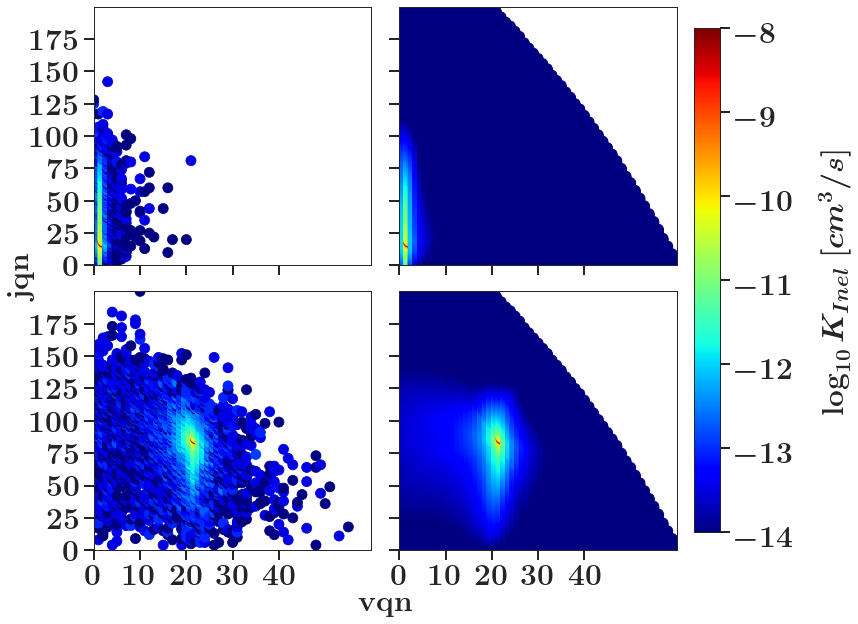

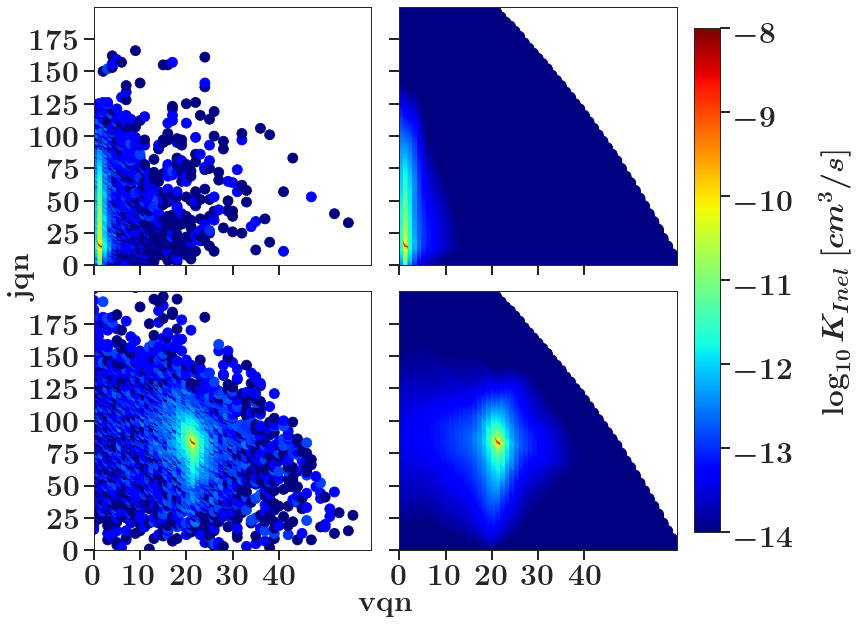

In [26]:
for TTran in TTranVec:
    Str = 'q_'+str(int(TTran))

    # Read Rates
    PathToHDF5File = System.PathToHDF5Fld+System.Name+'.hdf5'
    System = read_HDF5(System, PathToHDF5File, TTran, TTran)

    fig, axs = plt.subplots(2,2,sharey=True,sharex=True,figsize=(12,10))
    iplot = 0
    iplotc = 0
    for iIdx in tqdm(iIdxVec, desc='[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes'):
        iIdx -= 1
        print('Level: '+str(iIdx)+'; vqn: '+str(DiatData[0]['vqn'].to_numpy()[iIdx])+'; jqn:'+str(DiatData[0]['jqn'].to_numpy()[iIdx]))
        time.sleep(0.02)

        if (InputData.ExoEndoFlg):
            jIdxVec           = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] <= DiatData[0]['EInt'].to_numpy()[iIdx])]
            jIdxVecNo         = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] > DiatData[0]['EInt'].to_numpy()[iIdx])]
            RatioNo           = [DiatData[0][Str].to_numpy()[iIdx]/DiatData[1][Str].to_numpy()[jIdx] for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] > DiatData[0]['EInt'].to_numpy()[iIdx])]
        else:
            jIdxVec           = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    >= DiatData[0][Str].to_numpy()[iIdx])]
            jIdxVecNo         = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    < DiatData[0][Str].to_numpy()[iIdx])]
            RatioNo           = [DiatData[0][Str].to_numpy()[iIdx]/DiatData[1][Str].to_numpy()[jIdx] for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    < DiatData[0][Str].to_numpy()[iIdx])]
        jNLevels              = len(jIdxVec)
        jNLevelsNo            = len(jIdxVecNo)  

        ### FWD Rates
        iiIdxVec              = [iIdx]*jNLevels

        iTTranVec              = np.ones((jNLevels))*TTran
        TTranDataTemp         = pd.DataFrame({'TTran': iTTranVec})
        TTranDataTemp.index   = jIdxVec


        iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
        iLevelsDataTemp.index = jIdxVec

        jLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
        if (OtherVar == '_Delta'):
            jLevelsDataTemp   = iLevelsDataTemp.subtract(jLevelsDataTemp) 
        else:
            jLevelsDataTemp   = jLevelsDataTemp
        jLevelsDataTemp.index = jIdxVec

        kLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
        kLevelsDataTemp.index = jIdxVec


        iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

        jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
        jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

        kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        kLevelsData.columns   = [(VarName + '_j') for VarName in kLevelsData.columns]

        xTemp_FWD             = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)

        if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
            KExcit_NN_FWD          = np.exp( NN_KExcit.Model.predict(xTemp_FWD[NN_KExcit.xTrainingVar]) ) / InputData.MultFact 

        ## BWD Rates
        iiIdxVec              = jIdxVecNo
        jIdxVec               = [iIdx]*jNLevelsNo

        iTTranVec              = np.ones((jNLevelsNo))*TTran
        TTranDataTemp         = pd.DataFrame({'TTran': iTTranVec})
        TTranDataTemp.index   = iiIdxVec


        iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
        iLevelsDataTemp.index = iiIdxVec

        jLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy() 
        jLevelsDataTemp.index = iiIdxVec
        if (OtherVar == '_Delta'):
            jLevelsDataTemp   = iLevelsDataTemp.subtract(jLevelsDataTemp) 
        else:
            jLevelsDataTemp   = jLevelsDataTemp

        kLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
        kLevelsDataTemp.index = iiIdxVec


        iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

        jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
        jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

        kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        kLevelsData.columns   = [(VarName + '_j') for VarName in kLevelsData.columns]

        xTempp_BWD            = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)

        if (len(xTempp_BWD[NN_KExcit.xTrainingVar]) > 0):
            KExcit_NN_BWD          = np.exp( NN_KExcit.Model.predict(xTempp_BWD[NN_KExcit.xTrainingVar]) ) / InputData.MultFact 
            KExcit_NN_BWD[:,0]     = KExcit_NN_BWD[:,0] / RatioNo

            iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
            iLevelsData.columns   = [(VarName + '_j') for VarName in iLevelsData.columns]

            jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
            jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

            kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
            kLevelsData.columns   = [(VarName + '_i') for VarName in kLevelsData.columns]

            xTemp_BWD             = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)

        ### Concatenating
            if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
                xTemp     = pd.concat([xTemp_FWD, xTemp_BWD], axis=0)
                KExcit_NN = np.concatenate((KExcit_NN_FWD, KExcit_NN_BWD), axis=0)
            else:
                xTemp     = xTemp_BWD
                KExcit_NN = KExcit_NN_BWD
        else:
            if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
                xTemp     = xTemp_FWD
                KExcit_NN = KExcit_NN_FWD

        ### Plotting
        Mask     = System.Rates.KInel[iIdx,:] > MinRate

        vmax     = -8
        vmin     = -14

        cdict = {
          'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
          'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
          'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
        }
        
        axs[iplotc][iplot].scatter(DiatData[1]['vqn'][Mask], DiatData[1]['jqn'][Mask],s=100, c=np.log10(System.Rates.KInel[iIdx,Mask]), vmin=vmin, vmax=vmax,cmap='jet')
        axs[iplotc][iplot].set_xlim([DiatData[1]['vqn'].min(), DiatData[1]['vqn'].max()])
        axs[iplotc][iplot].set_ylim([DiatData[1]['jqn'].min(), 200])

        sc = axs[iplotc][iplot+1].scatter(xTemp['vqn_j'], xTemp['jqn_j'], c=np.log10(KExcit_NN[:,0]),s=100, vmin=vmin, vmax=vmax,cmap='jet')
        axs[iplotc][iplot+1].set_xlim([DiatData[1]['vqn'].min(), DiatData[1]['vqn'].max()])
        axs[iplotc][iplot+1].set_ylim([DiatData[1]['jqn'].min(), 200])
        axs[iplotc][iplot+1].set_xticks([0,10,20,30,40])
        axs[iplotc][iplot+1].set_yticks([0,25,50,75,100,125,150,175])

        iplotc = iplotc + 1
    
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel('\\textbf{vqn}',labelpad=40)
    plt.ylabel('\\textbf{jqn}',labelpad=60)
    
#     fig.subplots_adjust(right=0.8)
    fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label('$\log_{10}{K_{Inel}}$ \\textbf{[}$cm^3/s$\\textbf{]}', rotation=90,labelpad=25,size=30)

#     fig.tight_layout(pad=2.0) 
#     plt.savefig((Figure_ME_path+System.Name+'_T'+str(TTran)+'K_KInel.pdf'), format='pdf',dpi=600)


[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database_semiClassicalApprox/N3_NASA.hdf5


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes: 100%|██████████| 6/6 [00:00<00:00, 44.69it/s]
<ipython-input-37-9a7c784b148a>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


Level: 1025; vqn: 10; jqn:50
Level: 6099; vqn: 43; jqn:40
Level: 7199; vqn: 11; jqn:184
Level: 1199; vqn: 0; jqn:124
Level: 9199; vqn: 10; jqn:232
Level: 4517; vqn: 25; jqn:100
[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database_semiClassicalApprox/N3_NASA.hdf5


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes: 100%|██████████| 6/6 [00:00<00:00, 44.89it/s]


Level: 1025; vqn: 10; jqn:50
Level: 6099; vqn: 43; jqn:40
Level: 7199; vqn: 11; jqn:184
Level: 1199; vqn: 0; jqn:124
Level: 9199; vqn: 10; jqn:232
Level: 4517; vqn: 25; jqn:100


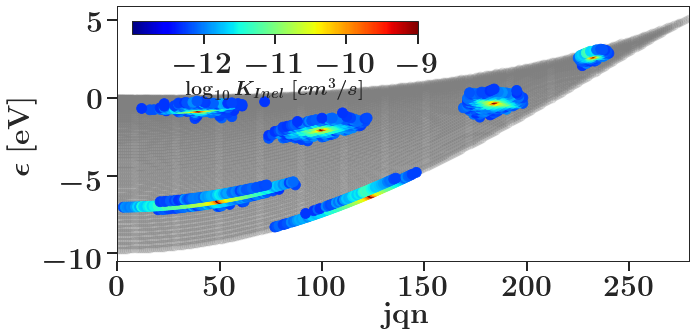

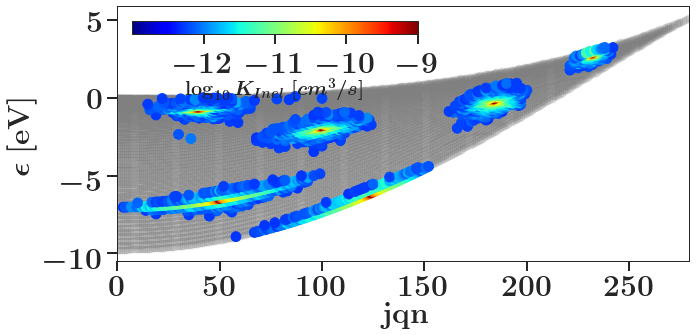

In [37]:
# iIdxVec             = np.array([110,3500, 7400, 1200, 9000, 2392], dtype=int)

iIdxVec             = np.array([1026, 6100, 7200, 1200, 9200, 4518], dtype=int)

for TTran in TTranVec:
    Str = 'q_'+str(int(TTran))

    # Read Rates
    PathToHDF5File = System.PathToHDF5Fld+System.Name+'.hdf5'
    System = read_HDF5(System, PathToHDF5File, TTran, TTran)

    fig, axs = plt.subplots(1,1,figsize=(10,5))
    sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=50, c='grey',alpha=0.2)
    
    for iIdx in tqdm(iIdxVec, desc='[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes'):
        iIdx -= 1
        print('Level: '+str(iIdx)+'; vqn: '+str(DiatData[0]['vqn'].to_numpy()[iIdx])+'; jqn:'+str(DiatData[0]['jqn'].to_numpy()[iIdx]))
        time.sleep(0.02)

 
        ### Plotting
        Mask     = System.Rates.KInel[iIdx,:] > 5e-13

        vmax     = -9
        vmin     = -13
        
        sc = axs.scatter(DiatData[1]['jqn'][Mask], DiatData[1]['EInt'][Mask],s=100, c=np.log10(System.Rates.KInel[iIdx,Mask]), vmin=vmin, vmax=vmax,cmap='jet')
    
    axs.set_xlim([DiatData[1]['jqn'].min(), DiatData[1]['jqn'].max()])
#     axs.set_ylim([DiatData[1]['jqn'].min(), 200])
#     axs.set_xticks([0,10,20,30,40])
#     axs.set_yticks([0,25,50,75,100,125,150,175])

    axins1 = inset_axes(axs,
                        width="50%",  # width = 50% of parent_bbox width
                        height="5%",  # height : 5%
                        loc='upper left')
    
    cbar = fig.colorbar(sc, cax=axins1, orientation="horizontal", ticks=[-12,-11,-10,-9])
    axins1.xaxis.set_ticks_position("bottom")    
    cbar.set_label('$\log_{10}{K_{Inel}}$ \\textbf{[}$cm^3/s$\\textbf{]}',fontsize=20)

    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel('\\textbf{jqn}',labelpad=40)
    plt.ylabel('$\epsilon$ \\textbf{[eV]}',labelpad=80)
    
    
    fig.tight_layout(pad=2.0) 
    plt.savefig(('/home/venturi/WORKSPACE/SurQCT/0D/Figures/OUSD_poster/N2_T'+str(TTran)+'K_KInel.pdf'), format='pdf',dpi=600)


# NON Plots

In [26]:
SystName    = 'NON_UMN'
Initialize = getattr(Initialize_System,'Initialize_'+SystName)
System = Initialize()

QCT_ME_path    = Paths.Workspace_path + 'Air_Database/' + System.QCTMEPath
SurQCT_ME_path = Paths.Workspace_path + 'Air_Database/Run_0D_surQCT/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

Data_ME_path   = Paths.Surqct_path + '0D/Data/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'
Figure_ME_path = Paths.Surqct_path + '0D/Figures/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

print('QCT Master Equation Path    :', QCT_ME_path)
print('SurQCT Master Equation Path :', SurQCT_ME_path)
print('Data Master Equation Path   :', Data_ME_path)
print('Figures Master Equation Path:', Figure_ME_path)

QCT Master Equation Path    : /home/venturi/WORKSPACE/Air_Database/Run_0D/
SurQCT Master Equation Path : /home/venturi/WORKSPACE/Air_Database/Run_0D_surQCT/nondim_RunI9_E6_D55/
Data Master Equation Path   : /home/venturi/WORKSPACE/SurQCT/0D/Data/NON_UMN/nondim_RunI9_E6_D55/
Figures Master Equation Path: /home/venturi/WORKSPACE/SurQCT/0D/Figures/NON_UMN/nondim_RunI9_E6_D55/


In [27]:
SurQCTFldr          = Paths.Workspace_path + '/SurQCT/surqct/'
RatesType           = 'KExcit'
ExcitType           = 'KInel'
NNRunIdx            = 9

PathToRunFld        = SurQCTFldr + '/../' + RatesType + '/all_temperatures_nondim/' + ExcitType + '/' 

TTranVec            = [10000]
MinRate             = 1.e-15

iIdxVec             = np.array([50,2000], dtype=int)


# Reading Files
print("\n[SurQCT]: Loading Modules and Functions ...")

sys.path.insert(0, SurQCTFldr  + '/src/Reading/')
from Reading  import read_levelsdata, read_diatdata

InputFld = PathToRunFld + '/Run_' + str(NNRunIdx) + '/'
print(InputFld)
sys.path.insert(0, InputFld)

# Initialize Input Data
print("\n[SurQCT]: Keep Loading Modules and Functions...")
from SurQCT_Input import inputdata

print("\n[SurQCT]: Initializing Input ...")
InputData    = inputdata(WORKSPACE_PATH, SurQCTFldr)

Prefix                    = 'Run_'
InputData.NNRunIdx        = NNRunIdx
InputData.PathToRunFld    = InputData.PathToRunFld+'/'+Prefix+str(InputData.NNRunIdx)
InputData.PathToFigFld    = InputData.PathToRunFld+'/'+InputData.PathToFigFld
InputData.PathToParamsFld = InputData.PathToRunFld+'/'+InputData.PathToParamsFld
InputData.PathToDataFld   = InputData.PathToRunFld+'/Data/'                                                               
InputData.PathToParamsFld = InputData.PathToRunFld+'/Params/'

InputData.PathToHDF5File  = InputData.WORKSPACE_PATH  + '/Air_Database/HDF5_Database/NON_UMN.hdf5'
InputData.Molecules       = ['NO','NO'] 
InputData.PathToLevelsFile= [InputData.WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/NO_UMN_log_nd.csv',
                             InputData.WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/NO_UMN_log_nd.csv']
InputData.PathToDiatFile  = [InputData.WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/NO/UMN/Recomputed.inp',
                             InputData.WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/NO/UMN/Recomputed.inp'] 

# Read NN Model
print("\n[SurQCT]: Loading Final Modules ... ")

sys.path.insert(0, SurQCTFldr  + '/src/Model/' + InputData.ApproxModel + '/')
from Model import model


InputData.DefineModelIntFlg  = 0
InputData.TrainIntFlg        = 0
InputData.TransferFlg        = False
NN_KExcit                    = model(InputData, InputData.PathToRunFld, None, None)
NN_KExcit.load_params(InputData.PathToParamsFld)

OtherVar           = InputData.OtherVar
xVarsVec_i         = InputData.xVarsVec_i + ['vqn','jqn']
xVarsVec_Delta     = InputData.xVarsVec_Delta
xVarsVec           = list(set(xVarsVec_i) | set(xVarsVec_Delta))
print('[SurQCT]:   Reading Variables: ', xVarsVec)

InputData.MultFact = 1.e+9
MinValueTrain      = 1.e-16 * InputData.MultFact
MinValueTest       = 1.e-16 * InputData.MultFact
NoiseSD            = 1.e-13 * InputData.MultFact

NMolecules         = len(InputData.PathToLevelsFile)

InputData.iLevelsVecTest = list(np.array(InputData.iLevelsVecTest) - 1)

# Reading Levels Data
LevelsData = []
DiatData   = []
DiatData2  = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(InputData.PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(InputData.PathToDiatFile[iMol], InputData.Molecules[iMol], TTranVec, TTranVec)
    DiatData.append(DiatDataTemp)
    
    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)
    



[SurQCT]: Loading Modules and Functions ...
/home/venturi/WORKSPACE//SurQCT/surqct//../KExcit/all_temperatures_nondim/KInel//Run_9/

[SurQCT]: Keep Loading Modules and Functions...

[SurQCT]: Initializing Input ...

[SurQCT]: Loading Final Modules ... 
[SurQCT]:   Variables Selected for Training:
[SurQCT]:     x =  ['log_EVib_i', 'log_ERot_i', 'ri_i', 'log_rorMin_i', 'TTran_i', 'log_EVib_Delta', 'log_ERot_Delta', 'ri_Delta', 'log_rorMin_Delta', 'TTran_Delta']
[SurQCT]:     y =  KExcit
[SurQCT]:   Loading ML Model from Folder: /home/venturi/WORKSPACE//SurQCT/surqct//../KExcit/all_temperatures_nondim/KInel//Run_9/MyModel
[SurQCT]:   Restoring ML Model Weigths to File: /home/venturi/WORKSPACE//SurQCT/surqct//../KExcit/all_temperatures_nondim/KInel//Run_9/MyModel/MyWeights.h5
[SurQCT]:   Loading ML Model Parameters from File:  /home/venturi/WORKSPACE//SurQCT/surqct//../KExcit/all_temperatures_nondim/KInel//Run_9/Params//ModelCheckpoint/cp-1963.ckpt
[SurQCT]:   Reading Variables:  ['log_ro

In [28]:
# Read Rates
PathToHDF5File = System.PathToHDF5Fld+System.Name+'.hdf5'
System = read_HDF5(System, PathToHDF5File, TTran, TTran)

[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database/NON_UMN.hdf5


[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database/NON_UMN.hdf5


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes:   0%|          | 0/2 [00:00<?, ?it/s]

Level: 49; vqn: 1; jqn:13


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes:  50%|█████     | 1/2 [00:00<00:00,  1.32it/s]

Level: 1999; vqn: 4; jqn:128


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


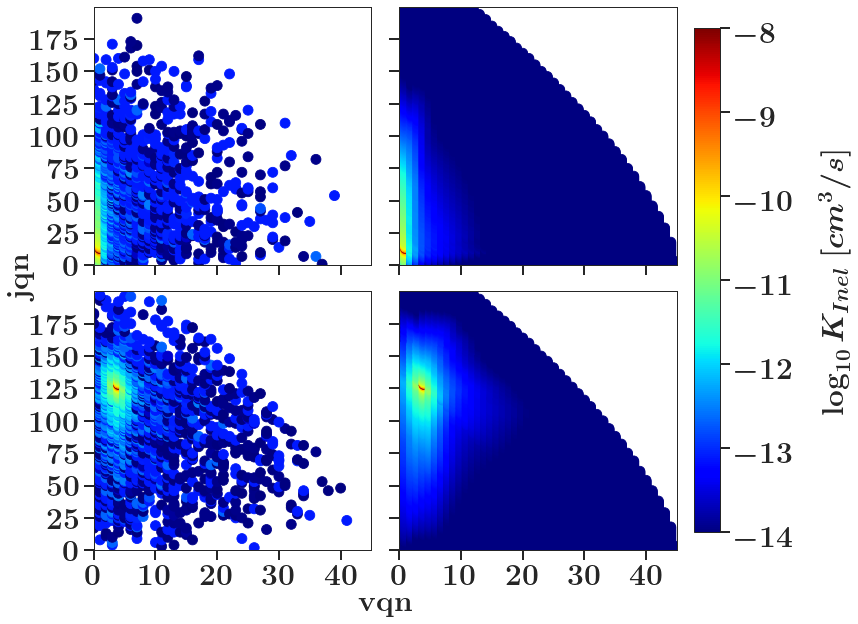

In [34]:
for TTran in TTranVec:
    Str = 'q_'+str(int(TTran))

    # Read Rates
    PathToHDF5File = System.PathToHDF5Fld+System.Name+'.hdf5'
    System = read_HDF5(System, PathToHDF5File, TTran, TTran)

    fig, axs = plt.subplots(2,2,sharey=True,sharex=True,figsize=(12,10))
    iplot = 0
    iplotc = 0
    for iIdx in tqdm(iIdxVec, desc='[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes'):
        iIdx -= 1
        print('Level: '+str(iIdx)+'; vqn: '+str(DiatData[0]['vqn'].to_numpy()[iIdx])+'; jqn:'+str(DiatData[0]['jqn'].to_numpy()[iIdx]))
        time.sleep(0.02)

        if (InputData.ExoEndoFlg):
            jIdxVec           = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] <= DiatData[0]['EInt'].to_numpy()[iIdx])]
            jIdxVecNo         = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] > DiatData[0]['EInt'].to_numpy()[iIdx])]
            RatioNo           = [DiatData[0][Str].to_numpy()[iIdx]/DiatData[1][Str].to_numpy()[jIdx] for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] > DiatData[0]['EInt'].to_numpy()[iIdx])]
        else:
            jIdxVec           = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    >= DiatData[0][Str].to_numpy()[iIdx])]
            jIdxVecNo         = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    < DiatData[0][Str].to_numpy()[iIdx])]
            RatioNo           = [DiatData[0][Str].to_numpy()[iIdx]/DiatData[1][Str].to_numpy()[jIdx] for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    < DiatData[0][Str].to_numpy()[iIdx])]
        jNLevels              = len(jIdxVec)
        jNLevelsNo            = len(jIdxVecNo)  

        ### FWD Rates
        iiIdxVec              = [iIdx]*jNLevels

        iTTranVec              = np.ones((jNLevels))*TTran
        TTranDataTemp         = pd.DataFrame({'TTran': iTTranVec})
        TTranDataTemp.index   = jIdxVec


        iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
        iLevelsDataTemp.index = jIdxVec

        jLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
        if (OtherVar == '_Delta'):
            jLevelsDataTemp   = iLevelsDataTemp.subtract(jLevelsDataTemp) 
        else:
            jLevelsDataTemp   = jLevelsDataTemp
        jLevelsDataTemp.index = jIdxVec

        kLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
        kLevelsDataTemp.index = jIdxVec


        iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

        jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
        jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

        kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        kLevelsData.columns   = [(VarName + '_j') for VarName in kLevelsData.columns]

        xTemp_FWD             = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)

        if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
            KExcit_NN_FWD          = np.exp( NN_KExcit.Model.predict(xTemp_FWD[NN_KExcit.xTrainingVar]) ) / InputData.MultFact 

        ## BWD Rates
        iiIdxVec              = jIdxVecNo
        jIdxVec               = [iIdx]*jNLevelsNo

        iTTranVec              = np.ones((jNLevelsNo))*TTran
        TTranDataTemp         = pd.DataFrame({'TTran': iTTranVec})
        TTranDataTemp.index   = iiIdxVec


        iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
        iLevelsDataTemp.index = iiIdxVec

        jLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy() 
        jLevelsDataTemp.index = iiIdxVec
        if (OtherVar == '_Delta'):
            jLevelsDataTemp   = iLevelsDataTemp.subtract(jLevelsDataTemp) 
        else:
            jLevelsDataTemp   = jLevelsDataTemp

        kLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
        kLevelsDataTemp.index = iiIdxVec


        iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

        jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
        jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

        kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        kLevelsData.columns   = [(VarName + '_j') for VarName in kLevelsData.columns]

        xTempp_BWD            = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)

        if (len(xTempp_BWD[NN_KExcit.xTrainingVar]) > 0):
            KExcit_NN_BWD          = np.exp( NN_KExcit.Model.predict(xTempp_BWD[NN_KExcit.xTrainingVar]) ) / InputData.MultFact 
            KExcit_NN_BWD[:,0]     = KExcit_NN_BWD[:,0] / RatioNo

            iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
            iLevelsData.columns   = [(VarName + '_j') for VarName in iLevelsData.columns]

            jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
            jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

            kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
            kLevelsData.columns   = [(VarName + '_i') for VarName in kLevelsData.columns]

            xTemp_BWD             = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)

        ### Concatenating
            if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
                xTemp     = pd.concat([xTemp_FWD, xTemp_BWD], axis=0)
                KExcit_NN = np.concatenate((KExcit_NN_FWD, KExcit_NN_BWD), axis=0)
            else:
                xTemp     = xTemp_BWD
                KExcit_NN = KExcit_NN_BWD
        else:
            if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
                xTemp     = xTemp_FWD
                KExcit_NN = KExcit_NN_FWD

        ### Plotting
        Mask     = System.Rates.KInel[iIdx,:] > MinRate

        vmax     = -8
        vmin     = -14

        cdict = {
          'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
          'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
          'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
        }
        
        axs[iplotc][iplot].scatter(DiatData[1]['vqn'][Mask], DiatData[1]['jqn'][Mask],s=100, c=np.log10(System.Rates.KInel[iIdx,Mask]), vmin=vmin, vmax=vmax,cmap='jet')
        axs[iplotc][iplot].set_xlim([DiatData[1]['vqn'].min(), DiatData[1]['vqn'].max()])
        axs[iplotc][iplot].set_ylim([DiatData[1]['jqn'].min(), 200])

        sc = axs[iplotc][iplot+1].scatter(xTemp['vqn_j'], xTemp['jqn_j'], c=np.log10(KExcit_NN[:,0]),s=100, vmin=vmin, vmax=vmax,cmap='jet')
        axs[iplotc][iplot+1].set_xlim([DiatData[1]['vqn'].min(), DiatData[1]['vqn'].max()])
        axs[iplotc][iplot+1].set_ylim([DiatData[1]['jqn'].min(), 200])
        axs[iplotc][iplot+1].set_xticks([0,10,20,30,40])
        axs[iplotc][iplot+1].set_yticks([0,25,50,75,100,125,150,175])

        iplotc = iplotc + 1
    
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel('\\textbf{vqn}',labelpad=40)
    plt.ylabel('\\textbf{jqn}',labelpad=60)
    
#     fig.subplots_adjust(right=0.8)
    fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label('$\log_{10}{K_{Inel}}$ \\textbf{[}$cm^3/s$\\textbf{]}', rotation=90,labelpad=25,size=30)

#     fig.tight_layout(pad=2.0) 
    plt.savefig((Figure_ME_path+System.Name+'_T'+str(TTran)+'K_KInel.pdf'), format='pdf',dpi=600)


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes: 100%|██████████| 6/6 [00:00<00:00, 44.28it/s]

[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database/NON_UMN.hdf5
Level: 796; vqn: 3; jqn:89
Level: 2826; vqn: 20; jqn:75
Level: 4659; vqn: 38; jqn:19
Level: 1199; vqn: 12; jqn:46
Level: 6599; vqn: 7; jqn:212
Level: 4517; vqn: 13; jqn:144



<ipython-input-33-6dc9cb5a99d4>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


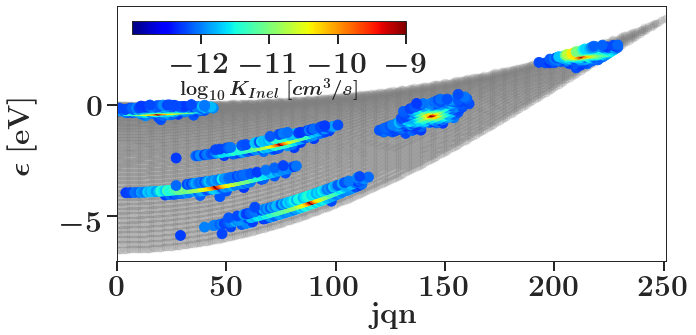

In [33]:
# iIdxVec             = np.array([110,3500, 7400, 1200, 9000, 2392], dtype=int)

iIdxVec             = np.array([797, 2827, 4660, 1200, 6600, 4518], dtype=int)

for TTran in TTranVec:
    Str = 'q_'+str(int(TTran))

    # Read Rates
    PathToHDF5File = System.PathToHDF5Fld+System.Name+'.hdf5'
    System = read_HDF5(System, PathToHDF5File, TTran, TTran)

    fig, axs = plt.subplots(1,1,figsize=(10,5))
    sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=50, c='grey',alpha=0.2)
    
    for iIdx in tqdm(iIdxVec, desc='[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes'):
        iIdx -= 1
        print('Level: '+str(iIdx)+'; vqn: '+str(DiatData[0]['vqn'].to_numpy()[iIdx])+'; jqn:'+str(DiatData[0]['jqn'].to_numpy()[iIdx]))
        time.sleep(0.02)

 
        ### Plotting
        Mask     = System.Rates.KInel[iIdx,:] > 5e-13

        vmax     = -9
        vmin     = -13
        
        sc = axs.scatter(DiatData[1]['jqn'][Mask], DiatData[1]['EInt'][Mask],s=100, c=np.log10(System.Rates.KInel[iIdx,Mask]), vmin=vmin, vmax=vmax,cmap='jet')
    
    axs.set_xlim([DiatData[1]['jqn'].min(), DiatData[1]['jqn'].max()])
#     axs.set_ylim([DiatData[1]['jqn'].min(), 200])
#     axs.set_xticks([0,10,20,30,40])
#     axs.set_yticks([0,25,50,75,100,125,150,175])

    axins1 = inset_axes(axs,
                        width="50%",  # width = 50% of parent_bbox width
                        height="5%",  # height : 5%
                        loc='upper left')
    
    cbar = fig.colorbar(sc, cax=axins1, orientation="horizontal", ticks=[-12,-11,-10,-9])
    axins1.xaxis.set_ticks_position("bottom")    
    cbar.set_label('$\log_{10}{K_{Inel}}$ \\textbf{[}$cm^3/s$\\textbf{]}',fontsize=20)

    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel('\\textbf{jqn}',labelpad=40)
    plt.ylabel('$\epsilon$ \\textbf{[eV]}',labelpad=80)
    
    
    fig.tight_layout(pad=2.0) 
    plt.savefig(('/home/venturi/WORKSPACE/SurQCT/0D/Figures/OUSD_poster/NO_T'+str(TTran)+'K_KInel.pdf'), format='pdf',dpi=600)


In [30]:
print(NLevels)

[6739, 6739]
